In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import xgboost as xgb
import statsmodels.api as sm

### Load data

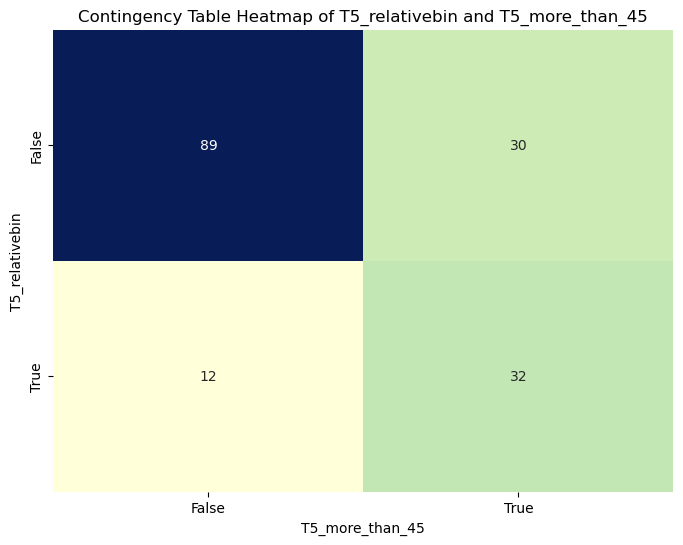

In [24]:
# Load the new voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_relative'] = ML_df['T5']/ML_df['T0']
ML_df['T5_relativebin'] = ML_df['T5_relative'] >= 1

ML_df['T5_more_than_45'] = ML_df['T5'] > 45
ML_df['T5_recovered'] = (ML_df['T5_relativebin']) & (ML_df['T5_more_than_45'])

ML_df['Outcome'] = (ML_df['T5_relativebin'].astype(int) * 2) + ML_df['T5_more_than_45'].astype(int)

# Create a contingency table
contingency_table = pd.crosstab(ML_df['T5_relativebin'], ML_df['T5_more_than_45'])

# Plot the contingency table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Contingency Table Heatmap of T5_relativebin and T5_more_than_45')
plt.xlabel('T5_more_than_45')
plt.ylabel('T5_relativebin')
plt.show()

### Data Imputation

In [42]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume ML_df is your DataFrame
# data_clean is data met Imputation
# data is data zonder imputation
data_clean = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80 - removed
# if 'T5' in data_clean.columns:
#     data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
data_clean

# Output the missing values check
missing_values_final_check.sum()

# t5_cleaned = data_clean['T5_relative'].replace([np.inf, -np.inf], np.nan).dropna()

# Define features and target
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_relativebin', 'T5_more_than_45', 'T5_recovered', 'Outcome'])
y = data_clean['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #stratify = y


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,pat_sexe,T0_age,T0_BMI,T0_VVMI_per,Education,household,Tumorlocation_strat,T0_Tumorsize,T0_ASA,T0_diseaseburden_cat,...,T0_CT_SMI,T0_CT_SMRA,T0_ASM_low,t0_gses_totaal_score,T0_participation_ability,T0_participation_satisfaction,t0_EQ_5D_5L_beschrijvend-systeem_score,T0_anxiety_cat,T0_depression_cat,T0
161,1,68.0,31.876367,95.0,2.0,1.0,3,8.0,2,2.0,...,45.637124,25.250562,0.0,30.0,51.547,50.197,0.593,0.0,0.0,49.903
131,0,59.0,24.483879,5.0,1.0,1.0,1,1.0,2,0.0,...,46.343972,42.630354,0.0,38.0,51.547,50.197,1.000,0.0,0.0,48.711
43,1,61.0,37.208448,95.0,2.0,1.0,1,3.0,3,1.0,...,44.110625,36.796983,0.0,35.0,51.547,50.197,0.852,0.0,0.0,42.273
132,0,50.0,27.646503,10.0,2.0,1.0,1,1.0,3,1.0,...,48.703417,30.030249,0.0,35.0,51.547,50.197,1.000,0.0,0.0,52.997
7,1,51.0,23.270824,10.0,2.0,1.0,4,4.0,2,1.0,...,44.110625,36.796983,0.0,35.0,51.547,50.197,0.704,0.0,1.0,45.353


### Best Modelling

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Recovered', 'Recovered'], 
                yticklabels=['Not Recovered', 'Recovered'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    best_features, initial_features, best_score = [], [], 0
    while True:
        scores = []
        for feature in X_train.columns:
            if feature not in initial_features:
                selected_features = initial_features + [feature]
                model.fit(X_train[selected_features], y_train)
                y_pred = model.predict(X_test[selected_features])
                accuracy = accuracy_score(y_test, y_pred)
                scores.append((accuracy, feature))

        if not scores: break
        
        current_score, best_feature = sorted(scores, reverse=True)[0]
        if current_score > best_score:
            best_score = current_score
            initial_features.append(best_feature)
            best_features.append(best_feature)
        else:
            break

    return best_features

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    if len(set(y_true)) == 2:  # Binary classification
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
    else:  # Multiclass classification
        specificity = np.nan  # Or handle multiclass specificity differently if needed
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'F1': f1}

# Train and evaluate models
def train_evaluate_model(model, name):
    features = forward_feature_selection(model, X_train, y_train, X_test, y_test)
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    metrics = calculate_metrics(y_test, y_pred)
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else np.abs(model.coef_[0])
    return metrics, features, importances

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
metrics_log_reg, features_log_reg, importances_log_reg = train_evaluate_model(log_reg, 'Logistic Regression')

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15)
metrics_tree, features_tree, importances_tree = train_evaluate_model(tree_model, 'Decision Tree')

# # Plot Decision Tree
# plt.figure(figsize=(10, 6))
# plot_tree(tree_model, feature_names=features_tree, class_names=['Not Recovered', 'Recovered'], filled=True)
# plt.show()

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
metrics_xgb, features_xgb, importances_xgb = train_evaluate_model(xgb_model, 'XGBoost')

# Null Model
class NullModel:
    def fit(self, X, y): self.mode = y.mode()[0]
    def predict(self, X): return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)
y_test_pred_null = null_model.predict(X_test)
metrics_null = calculate_metrics(y_test, y_test_pred_null)

# Feature importance plot
def plot_feature_importance(importances, features, title):
    plt.figure(figsize=(5, 3))
    sns.barplot(x=importances, y=features)
    plt.title(f'{title} Feature Importance')
    plt.show()

# Display results and plots
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Null Model'],
    'Accuracy': [metrics_log_reg['Accuracy'], metrics_tree['Accuracy'], metrics_xgb['Accuracy'], metrics_null['Accuracy']],
    'Precision': [metrics_log_reg['Precision'], metrics_tree['Precision'], metrics_xgb['Precision'], metrics_null['Precision']],
    'Recall': [metrics_log_reg['Recall'], metrics_tree['Recall'], metrics_xgb['Recall'], metrics_null['Recall']],
    'Specificity': [metrics_log_reg['Specificity'], metrics_tree['Specificity'], metrics_xgb['Specificity'], metrics_null['Specificity']],
    'F1': [metrics_log_reg['F1'], metrics_tree['F1'], metrics_xgb['F1'], metrics_null['F1']]
})
print(metrics_df)

# plot_feature_importance(importances_log_reg, features_log_reg, 'Logistic Regression')
# plot_feature_importance(importances_tree, features_tree, 'Decision Tree')
# plot_feature_importance(importances_xgb, features_xgb, 'XGBoost')

# plot_conf_matrix(y_test, log_reg.predict(X_test[features_log_reg]), 'Logistic Regression')
# plot_conf_matrix(y_test, tree_model.predict(X_test[features_tree]), 'Decision Tree')
# plot_conf_matrix(y_test, xgb_model.predict(X_test[features_xgb]), 'XGBoost')
# plot_conf_matrix(y_test, y_test_pred_null, 'Null Model')


                 Model  Accuracy  Precision   Recall  Specificity        F1
0  Logistic Regression   0.53125   0.493566  0.53125          NaN  0.490686
1        Decision Tree   0.59375   0.632440  0.59375          NaN  0.595565
2              XGBoost   0.68750   0.701042  0.68750          NaN  0.653947
3           Null Model   0.28125   0.079102  0.28125          NaN  0.123476


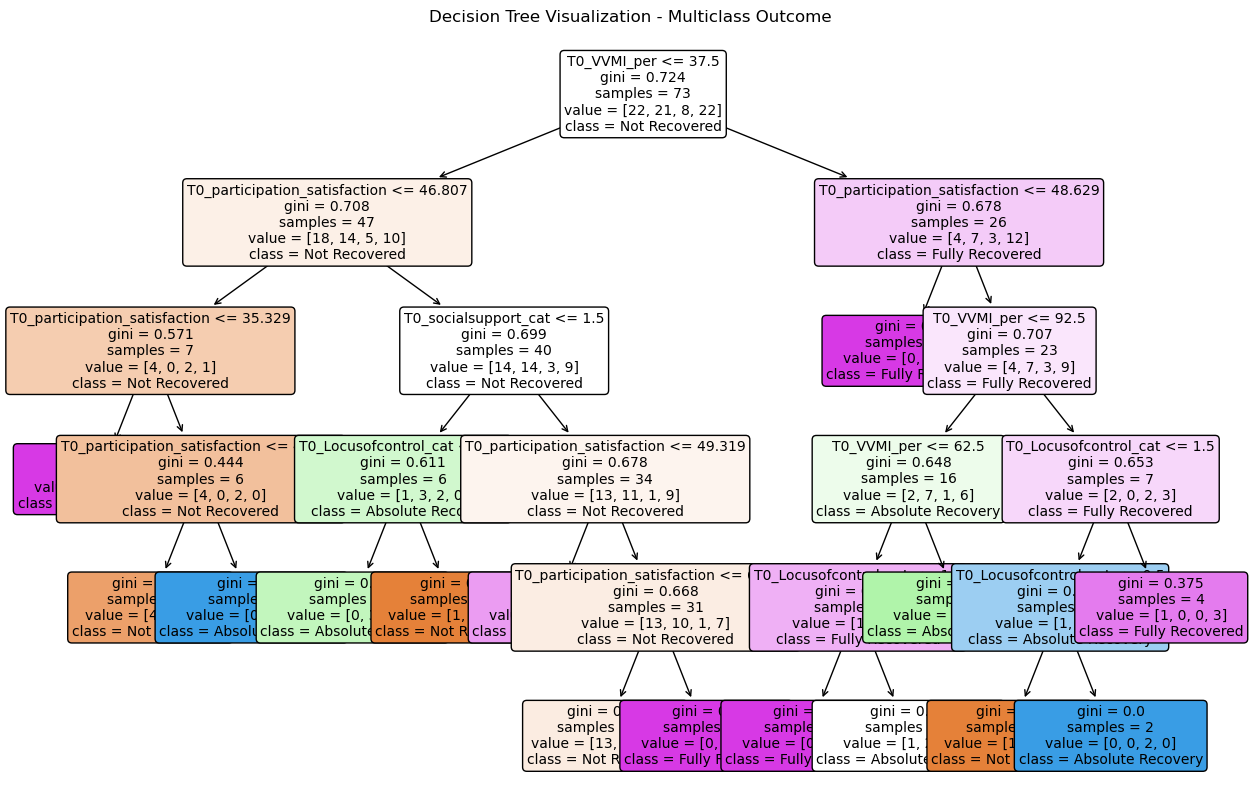

                 Model  Accuracy  Precision   Recall  Specificity        F1
0  Logistic Regression   0.53125   0.493566  0.53125          NaN  0.490686
1        Decision Tree   0.59375   0.632440  0.59375          NaN  0.595565
2              XGBoost   0.68750   0.701042  0.68750          NaN  0.653947
3           Null Model   0.28125   0.079102  0.28125          NaN  0.123476


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Recovered', 'Recovered'], 
                yticklabels=['Not Recovered', 'Recovered'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Forward feature selection function (improved)
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    best_features, initial_features, best_score = [], [], 0
    remaining_features = list(X_train.columns)
    while remaining_features:
        scores = []
        for feature in remaining_features:
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        if not scores: break
        
        current_score, best_feature = sorted(scores, reverse=True)[0]
        if current_score > best_score:
            best_score = current_score
            initial_features.append(best_feature)
            best_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return best_features

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() if len(set(y_true)) == 2 else (np.nan, np.nan, np.nan, np.nan)
    specificity = tn / (tn + fp) if tn is not np.nan else np.nan
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Specificity': specificity, 'F1': f1}

# Train and evaluate models
def train_evaluate_model(model, name):
    features = forward_feature_selection(model, X_train, y_train, X_test, y_test)
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    metrics = calculate_metrics(y_test, y_pred)
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else np.abs(model.coef_[0])
    return metrics, features, importances

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
metrics_log_reg, features_log_reg, importances_log_reg = train_evaluate_model(log_reg, 'Logistic Regression')

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15)
metrics_tree, features_tree, importances_tree = train_evaluate_model(tree_model, 'Decision Tree')

# Plot Decision Tree with labels
def plot_decision_tree_multiclass(model, features, y_train):
    # Define class labels for your three classes
    class_labels = ['Not Recovered', 'Absolute Recovery', 'Absolute Recovery', 'Fully Recovered']
    
    plt.figure(figsize=(15, 10))  # Adjust figure size to make it readable
    plot_tree(
        model, 
        feature_names=features, 
        class_names=class_labels,  # Use the multiclass labels
        filled=True, 
        rounded=True, 
        fontsize=10
    )
    plt.title("Decision Tree Visualization - Multiclass Outcome")
    plt.show()

# Call the plotting function for the decision tree
plot_decision_tree_multiclass(tree_model, features_tree, y_train)


# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
metrics_xgb, features_xgb, importances_xgb = train_evaluate_model(xgb_model, 'XGBoost')

# Null Model
class NullModel:
    def fit(self, X, y): self.mode = y.mode()[0]
    def predict(self, X): return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)
y_test_pred_null = null_model.predict(X_test)
metrics_null = calculate_metrics(y_test, y_test_pred_null)

# Feature importance plot
def plot_feature_importance(importances, features, title):
    plt.figure(figsize=(10, 15))
    sns.barplot(x=importances, y=features)
    plt.title(f'{title} Feature Importance')
    plt.show()

# Display results and plots
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Null Model'],
    'Accuracy': [metrics_log_reg['Accuracy'], metrics_tree['Accuracy'], metrics_xgb['Accuracy'], metrics_null['Accuracy']],
    'Precision': [metrics_log_reg['Precision'], metrics_tree['Precision'], metrics_xgb['Precision'], metrics_null['Precision']],
    'Recall': [metrics_log_reg['Recall'], metrics_tree['Recall'], metrics_xgb['Recall'], metrics_null['Recall']],
    'Specificity': [metrics_log_reg['Specificity'], metrics_tree['Specificity'], metrics_xgb['Specificity'], metrics_null['Specificity']],
    'F1': [metrics_log_reg['F1'], metrics_tree['F1'], metrics_xgb['F1'], metrics_null['F1']]
})
print(metrics_df)

# plot_feature_importance(importances_log_reg, features_log_reg, 'Logistic Regression')
# plot_feature_importance(importances_tree, features_tree, 'Decision Tree')
# plot_feature_importance(importances_xgb, features_xgb, 'XGBoost')

# plot_conf_matrix(y_test, log_reg.predict(X_test[features_log_reg]), 'Logistic Regression')
# plot_conf_matrix(y_test, tree_model.predict(X_test[features_tree]), 'Decision Tree')
# plot_conf_matrix(y_test, xgb_model.predict(X_test[features_xgb]), 'XGBoost')
# plot_conf_matrix(y_test, y_test_pred_null, 'Null Model')


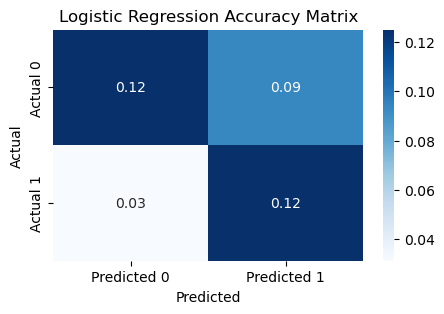

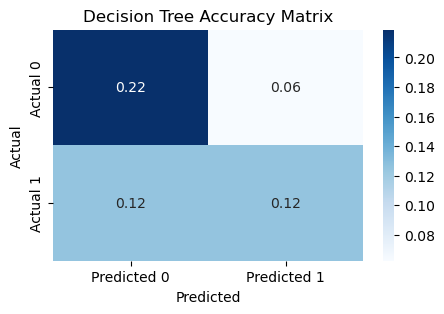

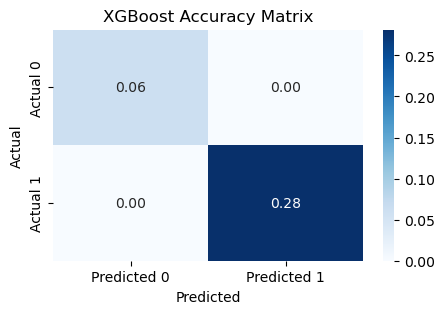

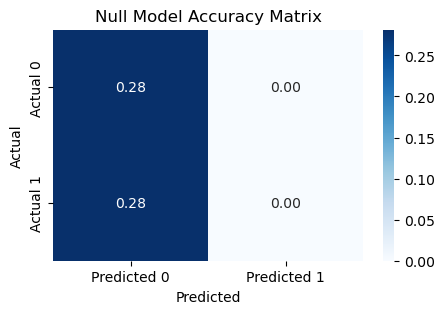

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to calculate accuracy matrix
def calculate_accuracy_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = len(y_true)
    
    accuracy_matrix = np.zeros((2, 2))
    
    for i in range(2):  # Binary classification: 0 and 1
        for j in range(2):
            # Calculate accuracy for each (true, predicted) combination
            correct_predictions = cm[i, j]
            accuracy_matrix[i, j] = correct_predictions / total_samples
    
    return accuracy_matrix

# Plot accuracy matrix
def plot_accuracy_matrix(y_true, y_pred, title):
    accuracy_matrix = calculate_accuracy_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(accuracy_matrix, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{title} Accuracy Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example usage for each model
plot_accuracy_matrix(y_test, log_reg.predict(X_test[features_log_reg]), 'Logistic Regression')
plot_accuracy_matrix(y_test, tree_model.predict(X_test[features_tree]), 'Decision Tree')
plot_accuracy_matrix(y_test, xgb_model.predict(X_test[features_xgb]), 'XGBoost')
plot_accuracy_matrix(y_test, y_test_pred_null, 'Null Model')


### T0 force

Initial accuracy with T0: 0.2812
Best features: ['T0', 'Time_pretreat_OK', 'T0_VVMI_per', 'T0_CT_SMRA']
Performance metrics: {'Accuracy': 0.59375, 'Precision': 0.6022588522588522, 'Recall': 0.6053030303030302, 'Specificity': nan, 'F1': 0.5989130434782608}


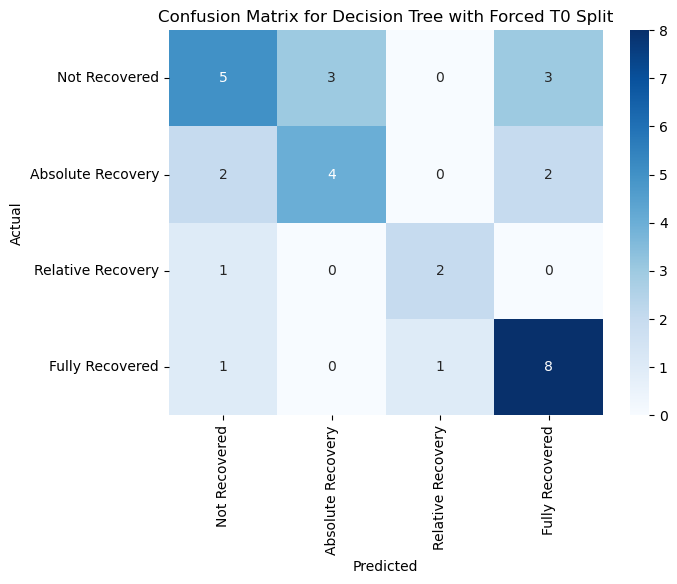

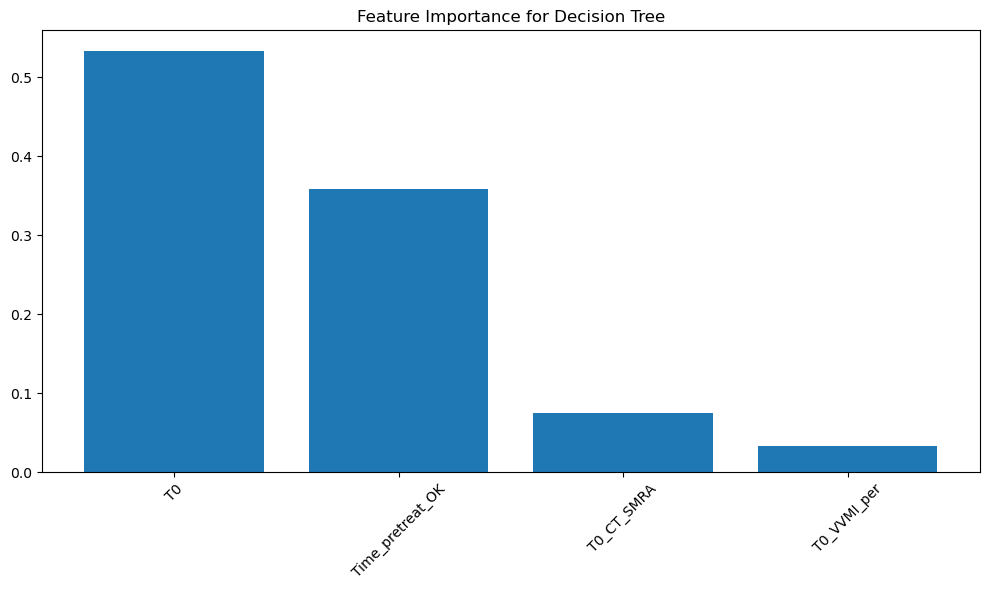

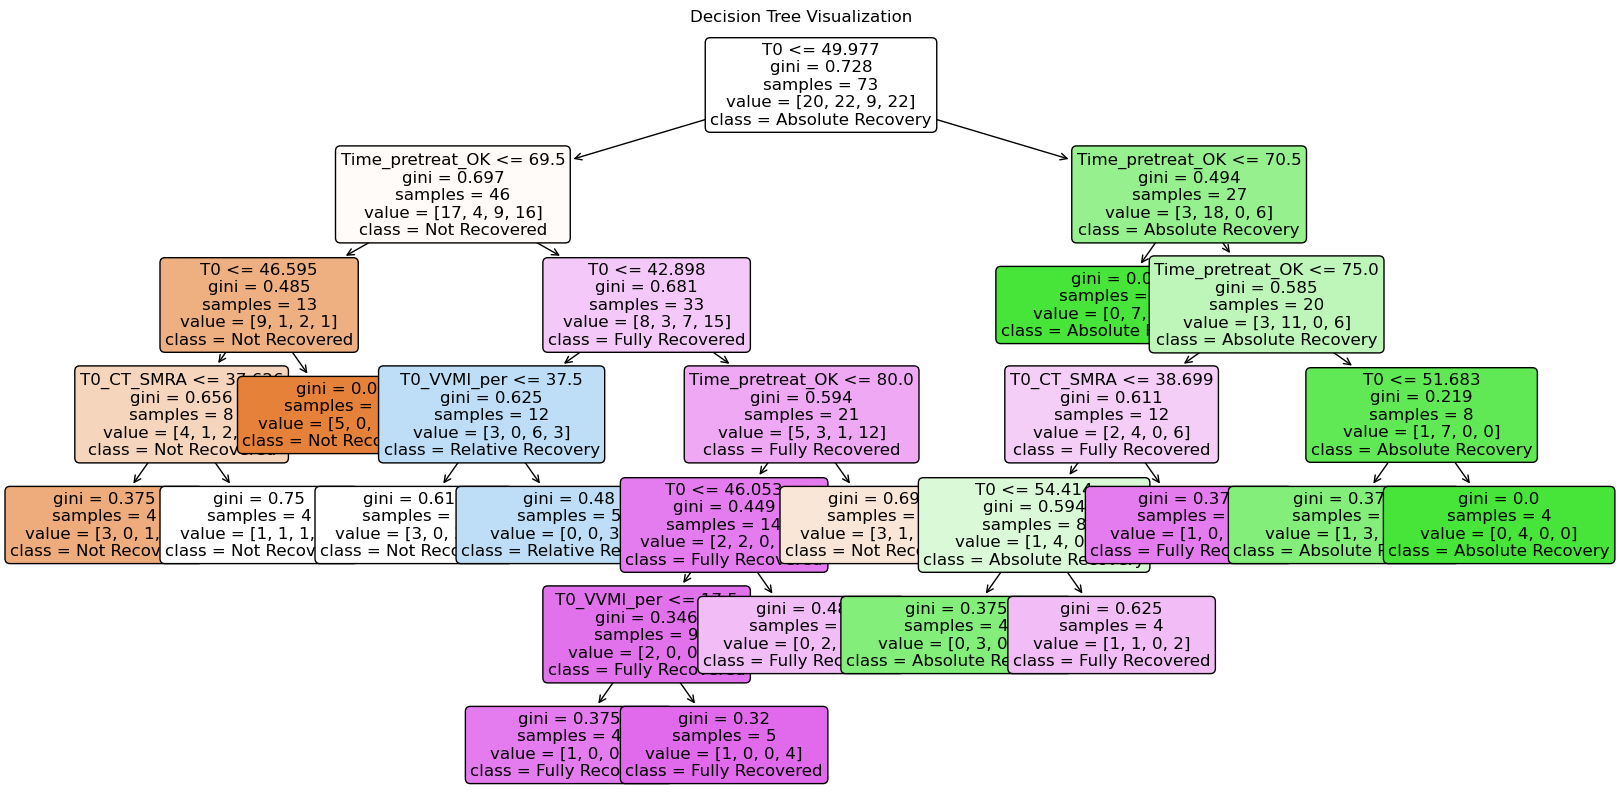

In [57]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Forward Feature Selection with T0 as First Split
def forward_feature_selection_with_T0(model, X_train, y_train, X_test, y_test):
    initial_features = ['T0']  # Force T0 to be used first
    best_features = ['T0']
    best_score = 0

    # Fit the model with only T0
    model.fit(X_train[['T0']], y_train)
    y_pred = model.predict(X_test[['T0']])
    best_score = accuracy_score(y_test, y_pred)

    print(f"Initial accuracy with T0: {best_score:.4f}")

    # Step 2: Forward selection of additional features
    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:  # Skip already selected features
                continue
            selected_features = best_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        if not scores:  # Exit if no more features to add
            break

        # Get the best feature in the current iteration
        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:  # Add the feature if it improves accuracy
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:  # Stop when no improvement
            break

    return best_features

# Step 3: Metrics Calculation Function
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)  # Adjusted for multiclass
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': np.nan,  # Not computed for multiclass here
        'F1': f1
    }

# Step 4: Model Training with Forward Selection
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=15, min_samples_leaf=4)

# Assuming X_train, y_train, X_test, and y_test are already defined and prepared
best_features_tree = forward_feature_selection_with_T0(tree_model, X_train, y_train, X_test, y_test)

# Step 5: Fit final model using the best features selected
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred_tree = tree_model.predict(X_test[best_features_tree])

# Step 6: Calculate and Display Metrics
metrics_tree = calculate_metrics(y_test, y_test_pred_tree)
print(f"Best features: {best_features_tree}")
print("Performance metrics:", metrics_tree)

# Step 7: Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_test_pred_tree, labels=[0, 1, 2, 3])
class_names = ['Not Recovered', 'Absolute Recovery', 'Relative Recovery', 'Fully Recovered']

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Decision Tree with Forced T0 Split')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Feature Importance Plot
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for Decision Tree")
plt.bar(range(len(best_features_tree)), importances[indices], align="center")
plt.xticks(range(len(best_features_tree)), [best_features_tree[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Step 9: Plot Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=best_features_tree,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Visualization")
plt.show()
